# Support Vector Machine assignment


## You have to classify  the data using the Tract features. To be able to do this you need to translate the tract features into something more compact.  You can think of variants of PTN(E), but not using the whole file. Tract feature histograms are also possible features. These can be calculated for a whole file, but it also possible to split the TF-plane. 

* You have to choose a positive and a negative class. 

* You have to propose your split between training and test data. Do you need a validation data aswell?

* Your final notebook should contain:

 * Two visualizations of the raw data. Can be a plot or a histogram but please familiarize yourself with the raw data. Each image should have captions explaining what is shown in the picture.

 * Clear indication what you picked as a positive class and what as the negative class.
 * Code calling an SVM implementation. Do you need to include slack? Can you control whether or not it is used?
 * A split in training and testing data. Why did you split the way you did?
 * Comparison with K-means turned into a classifier based on a majority vote, see cluster assignment.
 * Visualization of K-means and SVM classification results. Each image should have captions explaining what is shown in the picture.


In [40]:
# Packages for analysis
import pandas as pd
import numpy as np
from sklearn import svm
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import KFold    #  For cross validation

# Packages for visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Allows charts to appear in the notebook
%matplotlib inline

import scikitplot as skplt

In [2]:
# Read meta data, choose two classes for SVM assignment
esc50 = pd.read_csv('/home/meitao/Desktop/ESC-50/meta/esc50.csv')
#  31--->mouse click
esc50_a = esc50.loc[esc50['target'] == 31]
#  38--->clock tick
esc50_b = esc50.loc[esc50['target'] == 38]


 * Mouse clicking and clock ticking have similar features, a lot of peaks in horizatal direction

In [3]:
# Append two panda dataframes and reset the index
esc50_ab = esc50_a.append(esc50_b)
esc50_ab = esc50_ab.reset_index(level=0,drop=True)
esc50_ab

,filename,fold,target,category,esc10,src_file,take
0,1-118206-A-31.wav,1,31,mouse_click,False,118206,A
1,1-18655-A-31.wav,1,31,mouse_click,False,18655,A
2,1-45645-A-31.wav,1,31,mouse_click,False,45645,A
3,1-81851-A-31.wav,1,31,mouse_click,False,81851,A
4,1-85123-A-31.wav,1,31,mouse_click,False,85123,A
...,...,...,...,...,...,...,...
75,5-209833-A-38.wav,5,38,clock_tick,True,209833,A
76,5-210571-A-38.wav,5,38,clock_tick,True,210571,A
77,5-212181-A-38.wav,5,38,clock_tick,True,212181,A
78,5-219342-A-38.wav,5,38,clock_tick,True,219342,A


In [4]:
# Drop some of unuseful data
esc50_drop=esc50_ab.drop(['fold','esc10','src_file','take'],axis=1)

In [5]:
esc50_drop.head()
# make sure I have the data I need

,filename,target,category
0,1-118206-A-31.wav,31,mouse_click
1,1-18655-A-31.wav,31,mouse_click
2,1-45645-A-31.wav,31,mouse_click
3,1-81851-A-31.wav,31,mouse_click
4,1-85123-A-31.wav,31,mouse_click


 * Implementation of the used feature measures, with explanations how it works.
  * First I make functions to extract features, and then plot features. And to make comparison I also plot P&T features from PTN(E).

In [6]:
# function: use filename(***.wav) to extract features and make these features a array, then append to the csv

#####################################
######  For PTNE files   ############
#####################################


####   P   ######
def p_max(filename):
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/ptne/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    pulse=file['pulse']
    p_max=np.max(pulse[0])+np.max(pulse[1])+np.max(pulse[2])+np.max(pulse[3])+np.max(pulse[4])+np.max(pulse[5])
    return p_max
    

def p_mean(filename):
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/ptne/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    pulse=file['pulse']
    p_mean=np.mean(pulse[0])+np.mean(pulse[1])+np.mean(pulse[2])+np.mean(pulse[3])+np.mean(pulse[4])+np.mean(pulse[5])
    return p_mean

def p_min(filename):
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/ptne/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    pulse=file['pulse']
    p_min=np.min(pulse[0])+np.min(pulse[1])+np.min(pulse[2])+np.min(pulse[3])+np.min(pulse[4])+np.min(pulse[5])
    return p_min


#################   T   ##########
def t_max(filename):
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/ptne/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    tone=file['tone']
    t_max=np.max(tone[0])+np.max(tone[1])+np.max(tone[2])+np.max(tone[3])+np.max(tone[4])+np.max(tone[5])
    return t_max
    

def t_mean(filename):
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/ptne/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    tone=file['pulse']
    t_mean=np.mean(tone[0])+np.mean(tone[1])+np.mean(tone[2])+np.mean(tone[3])+np.mean(tone[4])+np.mean(tone[5])
    return t_mean

def t_min(filename):
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/ptne/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    tone=file['pulse']
    t_min=np.min(tone[0])+np.min(tone[1])+np.min(tone[2])+np.min(tone[3])+np.min(tone[4])+np.min(tone[5])
    return t_min


####################################################
######     builtding own Edb Features ##############
####################################################


#####   function to build my own Edb feature   ######

def E_feature(filename):
    sum_list=[]
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    E = np.asarray(file['E'])# save as np array
    #  delete first and last 6 rows
    #s_tract=np.delete(s_tract, np.s_[0:6:1], 0)
    #s_tract=np.delete(s_tract, np.s_[88:94:1], 0)  ##  88 rows now
    
    m,n = E.shape  #88  8499 ----> 8,100
    #print(m,n)
    #####################################################################
    # make a new a (similar) s_tract feature, with shape of 8*100    ####
    #####################################################################
    for i in range(10):   
        for j in range(99):
            a=np.sum(E[0+10*i:10+10*i, 0+85*j:85+85*j])
            sum_list.append(a)
        a=np.sum(E[0+10*i:10+10*i,8415:])  # because some file is not 8500 columns
        sum_list.append(a)
    feature_array=np.asarray(sum_list).reshape(10,100)  # get a new feature array like PTNE, but with better resolution
    log_feature_array=np.log(feature_array)   # Log 10 to the element of this array
    
    ######    plot test code: just to check my own feature
   # plt.imshow(log_feature_array,aspect='auto',origin='lower')
   # plt.colorbar()
   #plt.show()
    #s_tract_max=np.max(feature_array[0])+np.max(feature_array[1])+np.max(feature_array[2])+np.max(feature_array[3])+np.max(feature_array[4])+np.max(feature_array[5])+np.max(feature_array[6])+np.max(feature_array[7])
    return log_feature_array

###########################################################################
#  define O(.o.), for calculate pulse and tone features (similar to PTNE)
###########################################################################
def o_h(array,i,j):   
    m,n=array.shape
    if j==0:   # when it's the first col, return 0.5array[i,0]-0.5array[i,1]
        return 0.5*array[i][j]-0.5*array[i][j+1]
    elif j==n-1:  #when it comes to the last col
        return 0.5*array[i][j]-0.5*array[i][j-1]
    else:
        return array[i][j]-0.5*array[i][j-1]-0.5*array[i][j+1]
        
    
def o_v(array,i,j):
    m,n=array.shape
    if i==0:  # first row
        return 0.5*array[i][j]-0.5*array[i+1][j]
    elif i == m-1:  #last row
        return 0.5*array[i][j]-0.5*array[i-1][j]
    else:
        return array[i][j]-0.5*array[i-1][j]-0.5*array[i+1][j]

######################################################
###   pulse feature (similar to P)       #############
######################################################
def pulse_e(filename):
    E=E_feature(filename)  # E shape is 10*100
    m,n=E.shape
    pulse_e_list=[]
    for i in range(m):
        for j in range(n):
            pulse_e_list.append(o_h(E,i,j))
    pulse_e=np.asarray(pulse_e_list).reshape(10,100)
    pulse_e=np.absolute(pulse_e)
    #####################  plot test   ##############
    #plt.imshow(pulse_e,aspect='auto',origin='lower')
    #plt.colorbar()
    #plt.show()
    return pulse_e

######################################################
###    tone feature (similar to T)       #############
######################################################
def tone_e(filename):
    E=E_feature(filename)  # E shape is 10*100
    m,n=E.shape
    tone_e_list=[]
    for i in range(m):
        for j in range(n):
            tone_e_list.append(o_v(E,i,j))
    tone_e=np.asarray(tone_e_list).reshape(10,100)
    tone_e=np.absolute(tone_e)
    #####################  plot test   ##############
    #plt.imshow(tone_e,aspect='auto',origin='lower')
    #plt.colorbar()
    #plt.show()
    return tone_e


###### extract features from pulse_e and tone_e 


############   Pulse_e features  #######
def p_e_max(filename):
    p_e_max=0
    p_e = pulse_e(filename)  # E array has shape of 10*100
    for i in range (p_e.shape[0]):
        p_e_max+=np.max(p_e[i])
    return p_e_max
    
def p_e_min(filename):
    p_e_min=0
    p_e = pulse_e(filename)  # E array has shape of 10*100
    for i in range (p_e.shape[0]):
        p_e_min+=np.min(p_e[i])
    return p_e_min

def p_e_mean(filename):
    p_e_mean=0
    p_e = pulse_e(filename)  # E array has shape of 10*100
    for i in range (p_e.shape[0]):
        p_e_mean+=np.mean(p_e[i])
    return p_e_mean

############   Tone_e features  #######
def t_e_max(filename):
    t_e_max=0
    t_e = tone_e(filename)  # E array has shape of 10*100
    for i in range (t_e.shape[0]):
        t_e_max+=np.max(t_e[i])
    return t_e_max
    
def t_e_min(filename):
    t_e_min=0
    t_e = tone_e(filename)  # E array has shape of 10*100
    for i in range (t_e.shape[0]):
        t_e_min+=np.min(t_e[i])
    return t_e_min

def t_e_mean(filename):
    t_e_mean=0
    t_e = tone_e(filename)  # E array has shape of 10*100
    for i in range (t_e.shape[0]):
        t_e_mean+=np.mean(t_e[i])
    return t_e_mean

In [7]:
# make some empty lists to store values
p_max_list = []
p_mean_list = []
p_min_list = []
t_max_list = []
t_mean_list = []
t_min_list = []
s_tract_max_list=[]
s_tract_min_list=[]
s_tract_mean_list=[]
f_tract_max_list=[]
f_tract_min_list=[]
f_tract_mean_list=[]
p_e_max_list = []
p_e_min_list = []
p_e_mean_list = []
t_e_max_list = []
t_e_min_list = []
t_e_mean_list = []

* I have defined fuctions to extract features. Now I will extract features and put them (stack them) in the panda dataframe

In [8]:
for index, row in esc50_drop.iterrows():
    #using functions to get the feature values and store them in the list
    filename=row['filename']
    p_max_list.append(p_max(filename))
    p_min_list.append(p_min(filename))
    p_mean_list.append(p_mean(filename))
    
    t_max_list.append(t_max(filename))
    t_min_list.append(t_min(filename))
    t_mean_list.append(t_mean(filename))
    
    p_e_max_list.append(p_e_max(filename))
    p_e_min_list.append(p_e_min(filename))
    p_e_mean_list.append(p_e_mean(filename))
    
    t_e_max_list.append(t_e_max(filename))
    t_e_min_list.append(t_e_min(filename))
    t_e_mean_list.append(t_e_mean(filename))

# put these feature values into the pd.dataframe new columns
esc50_drop['p_max']=p_max_list
esc50_drop['p_min']=p_min_list
esc50_drop['p_mean']=p_mean_list

esc50_drop['t_max']=t_max_list
esc50_drop['t_min']=t_min_list
esc50_drop['t_mean']=t_mean_list

esc50_drop['p_e_max']=p_e_max_list
esc50_drop['p_e_min']=p_e_min_list
esc50_drop['p_e_mean']=p_e_mean_list

esc50_drop['t_e_max']=t_e_max_list
esc50_drop['t_e_min']=t_e_min_list
esc50_drop['t_e_mean']=t_e_mean_list


In [9]:
esc50_drop.head()
# make sure I have the features columns

,filename,target,category,p_max,p_min,p_mean,t_max,t_min,t_mean,p_e_max,p_e_min,p_e_mean,t_e_max,t_e_min,t_e_mean
0,1-118206-A-31.wav,31,mouse_click,401.084381,67.940018,198.396729,299.237335,67.940018,198.396729,59.632122,0.032238,8.568157,13.997195,0.471581,5.722444
1,1-18655-A-31.wav,31,mouse_click,375.588623,-109.630898,53.406158,328.404877,-109.630898,53.406158,60.351248,0.021365,7.801256,17.952473,0.071691,3.692888
2,1-45645-A-31.wav,31,mouse_click,389.135437,180.029343,283.787842,380.890930,180.029343,283.787842,26.295971,0.024266,3.862166,12.511619,0.048888,2.569113
3,1-81851-A-31.wav,31,mouse_click,453.135559,128.002365,257.242981,405.559113,128.002365,257.242981,61.113998,0.116883,10.698328,26.878989,2.119722,9.816382
4,1-85123-A-31.wav,31,mouse_click,363.881195,198.547195,288.546997,401.244476,198.547195,288.546997,20.403330,0.052849,3.536525,16.658787,0.440105,5.685079


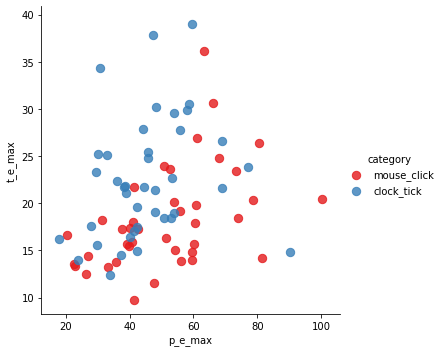

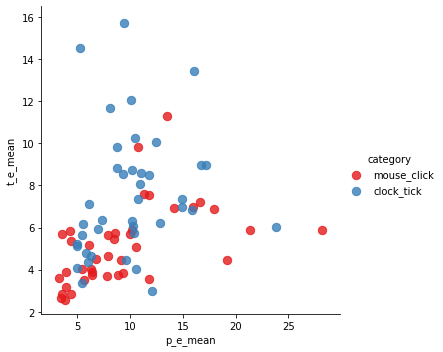

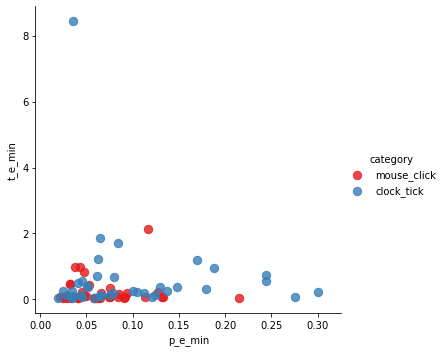

In [10]:
####   P_e feature comparing with the T_e feature


sns.lmplot('p_e_max','t_e_max', data=esc50_drop, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})


sns.lmplot('p_e_mean','t_e_mean', data=esc50_drop, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})


sns.lmplot('p_e_min','t_e_min', data=esc50_drop, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})



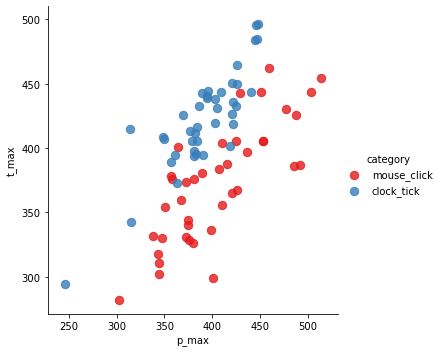

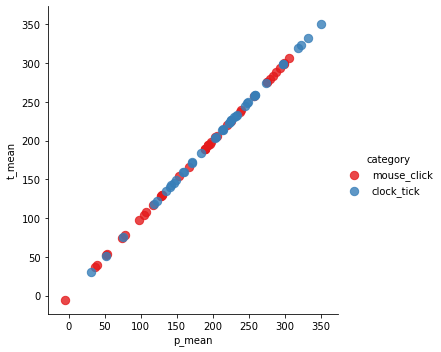

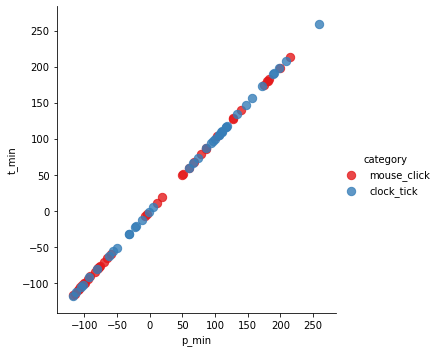

In [11]:
####   P feature comparing with the T feature


sns.lmplot('p_max','t_max', data=esc50_drop, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})
#plt.xlim(0)
#plt.ylim(0)

sns.lmplot('p_mean','t_mean', data=esc50_drop, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})
#plt.xlim(0)
#plt.ylim(0)

sns.lmplot('p_min','t_min', data=esc50_drop, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})
#plt.xlim(0)
#plt.ylim(0)


* From the above 6 plots, we can see that my own built p_e and t_e features are not as good as P T features. But you can still seperate red dots and blue dots in p_e_max and t_e_max plot. The blue dots are mostly above and the the red dots are mostly down below. One reason is that mouse_click and clock_tick both have strong peak in vertical direction, they do not change very much in tone direction. I will try to plot another sets of sound p_e features VS t_e features.

In [12]:
esc50_38 = esc50.loc[esc50['target'] == 38]
#  38--->clock tick
esc50_42 = esc50.loc[esc50['target'] == 42]
#  42--->siren
esc50_T_E_comparison2= esc50_38.append(esc50_42)
esc50_T_E_comparison2 = esc50_T_E_comparison2.reset_index(level=0,drop=True)
esc50_T_E_comparison2 = esc50_T_E_comparison2.drop(['fold','esc10','src_file','take'],axis=1)

esc50_T_E_comparison2 is data of **clock ticking** and **siren** features

In [13]:
p_max_list = []
p_mean_list = []
p_min_list = []
t_max_list = []
t_mean_list = []
t_min_list = []
s_tract_max_list=[]
s_tract_min_list=[]
s_tract_mean_list=[]
f_tract_max_list=[]
f_tract_min_list=[]
f_tract_mean_list=[]
p_e_max_list = []
p_e_min_list = []
p_e_mean_list = []
t_e_max_list = []
t_e_min_list = []
t_e_mean_list = []
for index, row in esc50_T_E_comparison2.iterrows():
    #using functions to get the feature values and store them in the list
    filename=row['filename']
    p_max_list.append(p_max(filename))
    p_min_list.append(p_min(filename))
    p_mean_list.append(p_mean(filename))
    
    t_max_list.append(t_max(filename))
    t_min_list.append(t_min(filename))
    t_mean_list.append(t_mean(filename))
    
    #s_tract_max_list.append(s_tract_max(filename))
    #s_tract_min_list.append(s_tract_min(filename))
    #s_tract_mean_list.append(s_tract_mean(filename))

    #f_tract_max_list.append(f_tract_max(filename))
    #f_tract_min_list.append(f_tract_min(filename))
    #f_tract_mean_list.append(f_tract_mean(filename))
    
    p_e_max_list.append(p_e_max(filename))
    p_e_min_list.append(p_e_min(filename))
    p_e_mean_list.append(p_e_mean(filename))
    
    t_e_max_list.append(t_e_max(filename))
    t_e_min_list.append(t_e_min(filename))
    t_e_mean_list.append(t_e_mean(filename))

# put these feature values into the pd.dataframe new columns
esc50_T_E_comparison2['p_max']=p_max_list
esc50_T_E_comparison2['p_min']=p_min_list
esc50_T_E_comparison2['p_mean']=p_mean_list

esc50_T_E_comparison2['t_max']=t_max_list
esc50_T_E_comparison2['t_min']=t_min_list
esc50_T_E_comparison2['t_mean']=t_mean_list

#esc50_drop['s_tract_max']=s_tract_max_list
#esc50_drop['s_tract_min']=s_tract_min_list
#esc50_drop['s_tract_mean']=s_tract_mean_list

#esc50_drop['f_tract_max']=f_tract_max_list
#esc50_drop['f_tract_min']=f_tract_min_list
#esc50_drop['f_tract_mean']=f_tract_mean_list

esc50_T_E_comparison2['p_e_max']=p_e_max_list
esc50_T_E_comparison2['p_e_min']=p_e_min_list
esc50_T_E_comparison2['p_e_mean']=p_e_mean_list

esc50_T_E_comparison2['t_e_max']=t_e_max_list
esc50_T_E_comparison2['t_e_min']=t_e_min_list
esc50_T_E_comparison2['t_e_mean']=t_e_mean_list

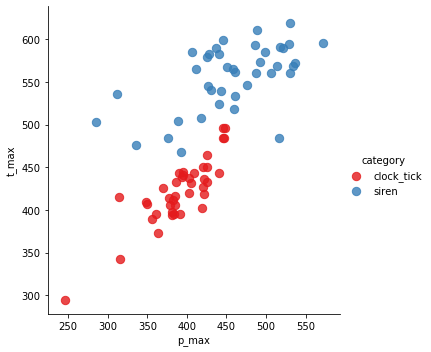

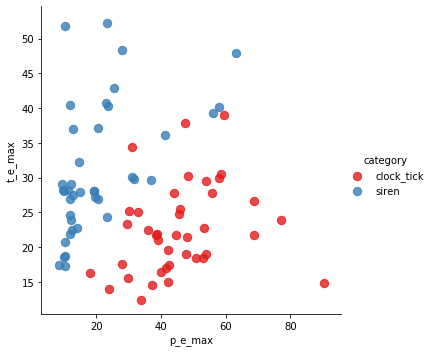

In [14]:
sns.lmplot('p_max','t_max', data=esc50_T_E_comparison2, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})

sns.lmplot('p_e_max','t_e_max', data=esc50_T_E_comparison2, hue='category',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})

* Now we can see in both the two plots, the feature dots seperate very well. Because one sound has peak in vertical direction and the other one has horizatal peak.

* From the plot above I choose to use p_e_max and t_e_max as my features

#### A split in training and testing data. Why did you split the way you did?
* I use sklearn.model_selection.train_test_split to split my data into training and test data. I set 20% of my data as test data, because if I split too many data to training data, I will not have enough test data, and if I have too little training data, my trained model might be not well trained. I think a split of 20% as test data is a good balance.

In [70]:
x = esc50_T_E_comparison2[['p_e_max','t_e_max']]  # data
n_features = x.shape[1]
y = esc50_T_E_comparison2['target']  # label
target_names=esc50_drop['filename']
n_classes = target_names.shape[0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) # split 20% as test data
x_train.head()

,p_e_max,t_e_max
49,56.215298,39.215703
30,17.907189,16.198509
79,11.340796,28.194635
75,12.690657,27.451580
17,40.125383,16.456023


In [71]:
#function to plot SVC decision line and margine
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

* I use sklearn.svm.SVC as my SVM, the way I control whether or not to include slack is to adjust the **"C"** value. With a smaller C I will get a bigger margin (softer margin).

### Visualization of SVM classification results. Each image should have captions explaining what is shown in the picture.

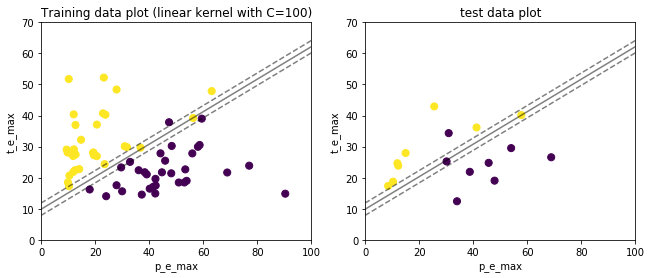

In [72]:
#   C=100
# plot the data using linear kernel svc with c=100
plt.subplot(1,2,1)
train_cmap=y_train
model_100 = SVC(kernel='linear', C=100)
model_100.fit(x_train, y_train)
plt.scatter(x_train['p_e_max'], x_train['t_e_max'], s=50, c=train_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
plt.title('Training data plot (linear kernel with C=100)')
plot_svc_decision_function(model_100)

# plot the test data and the SVC decision line
plt.subplot(1,2,2)
test_cmap=y_test
plt.scatter(x_test['p_e_max'], x_test['t_e_max'], s=50, c=test_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
plt.title('test data plot')
plot_svc_decision_function(model_100)

plt.subplots_adjust(right=1.5)
plt.show()

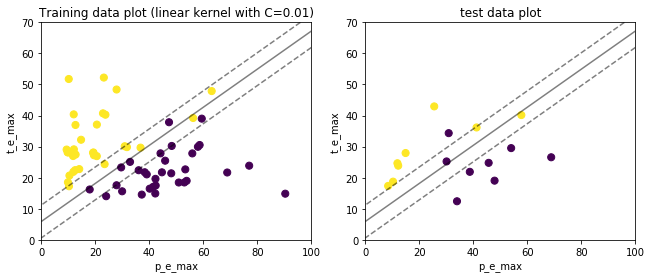

In [73]:
#   C=00.1
# plot the data using linear kernel svc with c=0.01

plt.subplot(1,2,1)
train_cmap=y_train
model_00_1 = SVC(kernel='linear', C=0.01)
model_00_1.fit(x_train, y_train)
plt.scatter(x_train['p_e_max'], x_train['t_e_max'], s=50, c=train_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
plt.title('Training data plot (linear kernel with C=0.01)')
plot_svc_decision_function(model_00_1)

# plot the test data and the SVC decision line
plt.subplot(1,2,2)
test_cmap=y_test
plt.scatter(x_test['p_e_max'], x_test['t_e_max'], s=50, c=test_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
plt.title('test data plot')
plot_svc_decision_function(model_00_1)
plt.subplots_adjust(right=1.5)
plt.show()



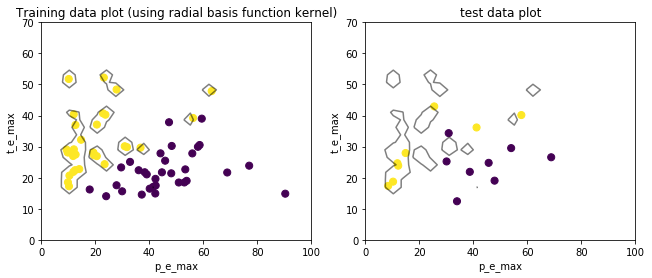

In [74]:
#   Using radial basis function kernel
plt.subplot(1,2,1)
train_cmap=y_train
model_rbf = SVC(kernel='rbf',gamma ='auto')
model_rbf.fit(x_train, y_train)
plt.scatter(x_train['p_e_max'], x_train['t_e_max'], s=50, c=train_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
#plt.xlim(200)
#plt.ylim(300)
plt.title('Training data plot (using radial basis function kernel)')
plot_svc_decision_function(model_rbf)

# plot the test data and the SVC decision line
plt.subplot(1,2,2)
test_cmap=y_test
plt.scatter(x_test['p_e_max'], x_test['t_e_max'], s=50, c=test_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
#plt.xlim(200)
#plt.ylim(300)
plt.title('test data plot')
plot_svc_decision_function(model_rbf)

plt.subplots_adjust(right=1.5)
plt.show()

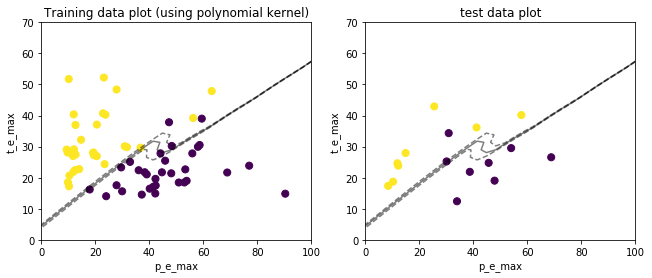

In [75]:
#   Using polynomial kernel
plt.subplot(1,2,1)
train_cmap=y_train
model_poly = SVC(kernel='poly',gamma ='auto')
model_poly.fit(x_train, y_train)
plt.scatter(x_train['p_e_max'], x_train['t_e_max'], s=50, c=train_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
#plt.xlim(200)
#plt.ylim(300)
plt.title('Training data plot (using polynomial kernel)')
plot_svc_decision_function(model_poly)

# plot the test data and the SVC decision line
plt.subplot(1,2,2)
test_cmap=y_test
plt.scatter(x_test['p_e_max'], x_test['t_e_max'], s=50, c=test_cmap)
plt.xlabel('p_e_max')
plt.ylabel('t_e_max')
plt.xlim(0,100)
plt.ylim(0,70)
#plt.xlim(100)
#plt.ylim(300)
plt.title('test data plot')
plot_svc_decision_function(model_poly)
plt.subplots_adjust(right=1.5)
plt.show()

### Comparison of different models:

In [76]:
model_00_1 = SVC(kernel='linear', C=0.01,probability=True)
model_00_1.fit(x_train, y_train)
probs_00_1 = model_00_1.predict_proba(x_test)
probs_00_1 = probs_00_1[:, 1]

model_100 = SVC(kernel='linear', C=100,probability=True)
model_100.fit(x_train, y_train)
probs_100 = model_100.predict_proba(x_test)
probs_100 = probs_100[:, 1]

model_rbf = SVC(kernel='rbf',gamma ='auto',probability=True)
model_rbf.fit(x_train, y_train)
probs_rbf = model_rbf.predict_proba(x_test)
probs_rbf = probs_rbf[:, 1]

model_poly = SVC(kernel='poly',gamma ='auto',probability=True)
model_poly.fit(x_train, y_train)
probs_poly = model_poly.predict_proba(x_test)
probs_poly = probs_poly[:, 1]


In [77]:
y_pred_100 = model_100.predict(x_test)
y_pred_00_1 = model_00_1.predict(x_test)
y_pred_rbf = model_rbf.predict(x_test)
y_pred_poly = model_poly.predict(x_test)
y_test_array=np.asarray(y_test)
print(y_pred_100)
print(y_pred_00_1)
print(y_pred_rbf)
print(y_pred_poly)
print(y_test_array)

[42 38 38 38 42 38 42 38 42 38 38 42 42 42 42 42]
[42 42 38 38 38 38 42 38 42 38 38 42 42 42 42 42]
[38 38 38 38 38 38 42 38 38 38 38 38 38 38 42 42]
[42 42 38 38 42 38 42 38 42 38 38 42 42 42 42 42]
[42 38 38 38 42 38 42 38 42 38 38 42 38 42 42 42]


In [78]:
# Model Accuracy:
print("Accuracy of model c=100:",metrics.accuracy_score(y_test, y_pred_100))
print("Accuracy of model c=0.01:",metrics.accuracy_score(y_test, y_pred_00_1))
print("Accuracy of model rbf kernel:",metrics.accuracy_score(y_test, y_pred_rbf))
print("Accuracy of model poly kernel:",metrics.accuracy_score(y_test, y_pred_poly))

Accuracy of model c=100: 0.9375
Accuracy of model c=0.01: 0.8125
Accuracy of model rbf kernel: 0.6875
Accuracy of model poly kernel: 0.875


Text(0.5, 1, 'confusion_matrix (Linear kernel c=100)')

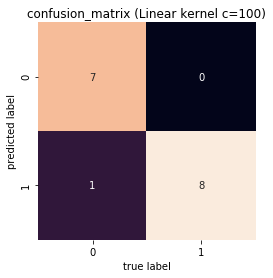

In [79]:
# Plot confusion_matrix
mat = confusion_matrix(y_test, y_pred_100)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('confusion_matrix (Linear kernel c=100)')

Text(0.5, 1, 'confusion_matrix (Linear kernel c=0.01)')

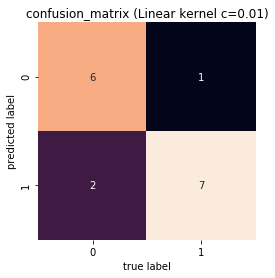

In [80]:
mat = confusion_matrix(y_test, y_pred_00_1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('confusion_matrix (Linear kernel c=0.01)')

Text(0.5, 1, 'confusion_matrix (RBF kernel)')

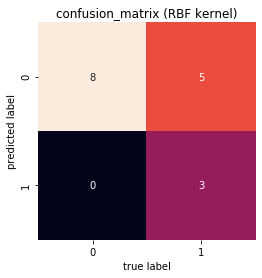

In [81]:
mat = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('confusion_matrix (RBF kernel)')

Text(0.5, 1, 'confusion_matrix (polynomial kernel)')

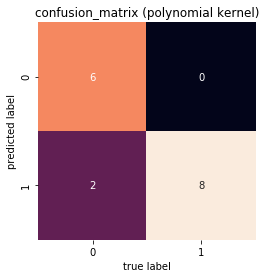

In [82]:
mat = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('confusion_matrix (polynomial kernel)')

### ROC Curve

I choose "38-clock tick" as negtive class, and "42-siren" as positive class.

In [83]:
for i in range(len(y_test_array)):
    if y_test_array[i] == 38:
        y_test_array[i]=0   # Neg class
    if y_test_array[i] == 42: 
        y_test_array[i]=1   # Pos class
     
print(y_test_array)

[1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1]


In [84]:
# calculate the FPR and TPR for 4 different SVM methods
fpr_rbf, tpr_rbf, thresholds_rbf = roc_curve(y_test_array, probs_rbf)
fpr_100, tpr_100, thresholds_100 = roc_curve(y_test_array, probs_100)
fpr_00_1, tpr_00_1, thresholds_00_1 = roc_curve(y_test_array, probs_00_1)
fpr_poly, tpr_poly, thresholds_poly = roc_curve(y_test_array, probs_poly)


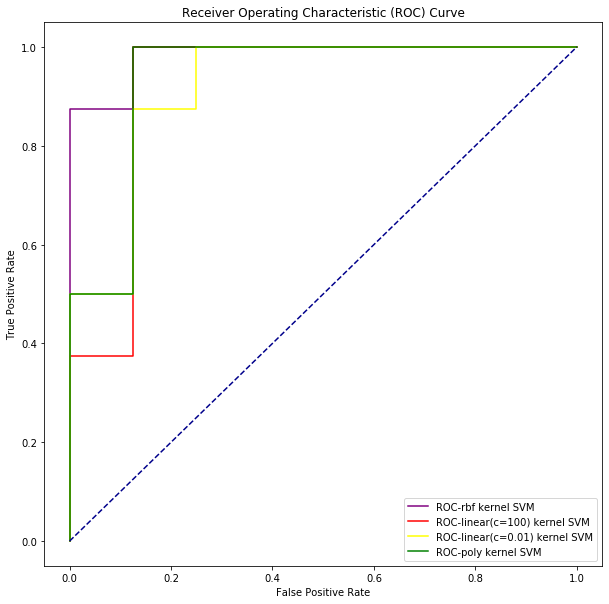

In [92]:
plt.figure(figsize=(10,10))
plt.plot(fpr_rbf, tpr_rbf, color='purple', label='ROC-rbf kernel SVM')
plt.plot(fpr_100, tpr_100, color='red', label='ROC-linear(c=100) kernel SVM')
plt.plot(fpr_00_1, tpr_00_1, color='yellow', label='ROC-linear(c=0.01) kernel SVM')
plt.plot(fpr_poly, tpr_poly, color='green', label='ROC-poly kernel SVM')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
#ROC curve for SVM(with rbf kernel)

In my case, positive class is "siren" and negtive class is "clock ticking". From the ROC curve I can tell that if we want to have a high accuacy prediction on pos class(siren), or to say we don't want to miss any "siren" sound, we should use "RBF kernel" SVM classifer because it has the highest TPR. And by contrast, if we don't want to miss any "clock ticking" sound, we should use "poly nernel" SVM classifer because it has the highest FPR.

### Comparison with K-means turned into a classifier based on a majority vote, see cluster assignment.
* The SVM seperates data by **"support vectors"**, those data that lie closest to the decision surface (or hyperplane). 
* For data points that are not easy to be linearly seperated, we can use **kernel** functions to transform them into higher dimisions.

### Do you need a validation data as well?

Spilit the all data into training and test data can cause problems, it may cause overfitting. What I should do is spilit data into training and test, and use part of the training data to train the model and rest of training data to do validation and adjust parameters to get a better model (can use K-fold cross validation and leave-one out cross validation ), and finally use test data to evaluate the model.